<a href="https://colab.research.google.com/github/Billie2005/Image-enhancing-model-mirnet/blob/main/Image_enhancing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#@title Install compatible deps and import TF's TFLite Interpreter
!pip -q install "numpy<2" pillow  # pin numpy < 2 for ABI-compat

import numpy as np, sys
print("NumPy version:", np.__version__)
print("If NumPy >= 2.0 is shown, please 'Runtime → Restart runtime' and run this cell again.")

import os, tarfile
from pathlib import Path
from PIL import Image

# Use TensorFlow's built-in TFLite
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.lite.python.interpreter import Interpreter  # <- key change
from tflite_runtime.interpreter import Interpreter

NumPy version: 2.0.2
If NumPy >= 2.0 is shown, please 'Runtime → Restart runtime' and run this cell again.
TensorFlow version: 2.19.0


In [24]:
#@title Mount Google Drive and load model (.tflite or .tar)
from google.colab import drive
drive.mount('/content/drive')

# 👉 Edit this to your model path in Drive:
drive_model_path = "/content/drive/MyDrive/Image enhancement model/1.tflite"  # or .tflite

work_dir = Path("/content/mirnet_model")
work_dir.mkdir(parents=True, exist_ok=True)

p = Path(drive_model_path)
if not p.exists():
    raise FileNotFoundError(f"Model not found at: {p}")

if p.suffix.lower() == ".tflite":
    model_path = str(p)
elif p.suffix.lower() == ".tar":
    with tarfile.open(p, "r") as tar:
        tar.extractall(work_dir)
    tflites = list(work_dir.rglob("*.tflite"))
    if len(tflites) == 0:
        raise FileNotFoundError("No .tflite found inside the TAR.")
    model_path = str(tflites[0])
else:
    raise ValueError("drive_model_path must end with .tflite or .tar")

print("✅ Model ready at:", model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model ready at: /content/drive/MyDrive/Image enhancement model/1.tflite


In [25]:
#@title Set input (file or folder) and output folder on Drive
# Set EITHER a single image OR a folder.
#drive_input_path = "/content/drive/MyDrive/lowlight_samples/IMG_001.jpg"   # file example
drive_input_path = "/content/drive/MyDrive/capstone night images"             # folder example

drive_output_dir = "/content/drive/MyDrive/mirnet_outputs"

in_p = Path(drive_input_path)
out_dir = Path(drive_output_dir)
out_dir.mkdir(parents=True, exist_ok=True)

valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

if in_p.is_file():
    input_images = [in_p]
elif in_p.is_dir():
    input_images = [q for q in in_p.iterdir() if q.suffix.lower() in valid_exts]
    input_images.sort()
else:
    raise FileNotFoundError(f"Input path not found: {in_p}")

print(f"Found {len(input_images)} image(s).")
if len(input_images) > 5:
    print("First 5:", [str(x) for x in input_images[:5]])

Found 17 image(s).
First 5: ['/content/drive/MyDrive/capstone night images/1.jpg', '/content/drive/MyDrive/capstone night images/10.jpg', '/content/drive/MyDrive/capstone night images/11.jpg', '/content/drive/MyDrive/capstone night images/12.jpg', '/content/drive/MyDrive/capstone night images/13.jpg']


In [26]:
# Helper functions (dynamic/fixed input supported) — uses TF's Interpreter
from pathlib import Path
from PIL import Image
import numpy as np
from tensorflow.lite.python.interpreter import Interpreter  # <-- TF's TFLite

def load_image_rgb(path: Path) -> Image.Image:
    return Image.open(path).convert("RGB")

def to_uint8_image(arr: np.ndarray) -> Image.Image:
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0.0, 1.0)
        arr = (arr * 255.0).round().astype(np.uint8)
    return Image.fromarray(arr)

def run_mirnet_tflite(model_path: str, input_image_path: Path, output_image_path: Path):
    interpreter = Interpreter(model_path=model_path)  # <- TF Interpreter
    interpreter.allocate_tensors()

    in_details = interpreter.get_input_details()[0]
    out_details = interpreter.get_output_details()[0]

    in_shape = list(in_details["shape"])  # [1,H,W,3] or [-1,-1,-1,3] if dynamic
    dynamic = any(d is None or d <= 0 for d in in_shape)

    img = load_image_rgb(input_image_path)
    np_img = np.array(img).astype("float32") / 255.0

    if dynamic:
        H, W = np_img.shape[:2]
        interpreter.resize_tensor_input(in_details["index"], [1, H, W, 3])
        interpreter.allocate_tensors()
    else:
        _, H, W, _ = in_shape
        img = img.resize((W, H), Image.LANCZOS)
        np_img = np.array(img).astype("float32") / 255.0

    x = np.expand_dims(np_img, 0)  # [1,H,W,3]
    interpreter.set_tensor(in_details["index"], x)
    interpreter.invoke()
    y = interpreter.get_tensor(out_details["index"])[0]

    out_img = to_uint8_image(y)
    out_img.save(output_image_path)
    return output_image_path

In [27]:
# Remove the fragile wheel and pin numpy
!pip -q uninstall -y tflite-runtime
!pip -q install "numpy<2" pillow

import numpy as np, tensorflow as tf
print("NumPy:", np.__version__)
print("TF   :", tf.__version__)

NumPy: 2.0.2
TF   : 2.19.0


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


[1/17] Saved: /content/drive/MyDrive/mirnet_outputs/1_enhanced.jpg
[2/17] Saved: /content/drive/MyDrive/mirnet_outputs/10_enhanced.jpg
[3/17] Saved: /content/drive/MyDrive/mirnet_outputs/11_enhanced.jpg
[4/17] Saved: /content/drive/MyDrive/mirnet_outputs/12_enhanced.jpg
[5/17] Saved: /content/drive/MyDrive/mirnet_outputs/13_enhanced.jpg
[6/17] Saved: /content/drive/MyDrive/mirnet_outputs/14_enhanced.jpg
[7/17] Saved: /content/drive/MyDrive/mirnet_outputs/15_enhanced.jpg
[8/17] Saved: /content/drive/MyDrive/mirnet_outputs/16_enhanced.jpg
[9/17] Saved: /content/drive/MyDrive/mirnet_outputs/17_enhanced.jpg
[10/17] Saved: /content/drive/MyDrive/mirnet_outputs/2_enhanced.jpg
[11/17] Saved: /content/drive/MyDrive/mirnet_outputs/3_enhanced.jpg
[12/17] Saved: /content/drive/MyDrive/mirnet_outputs/4_enhanced.jpg
[13/17] Saved: /content/drive/MyDrive/mirnet_outputs/5_enhanced.jpg
[14/17] Saved: /content/drive/MyDrive/mirnet_outputs/6_enhanced.jpg
[15/17] Saved: /content/drive/MyDrive/mirnet_outp

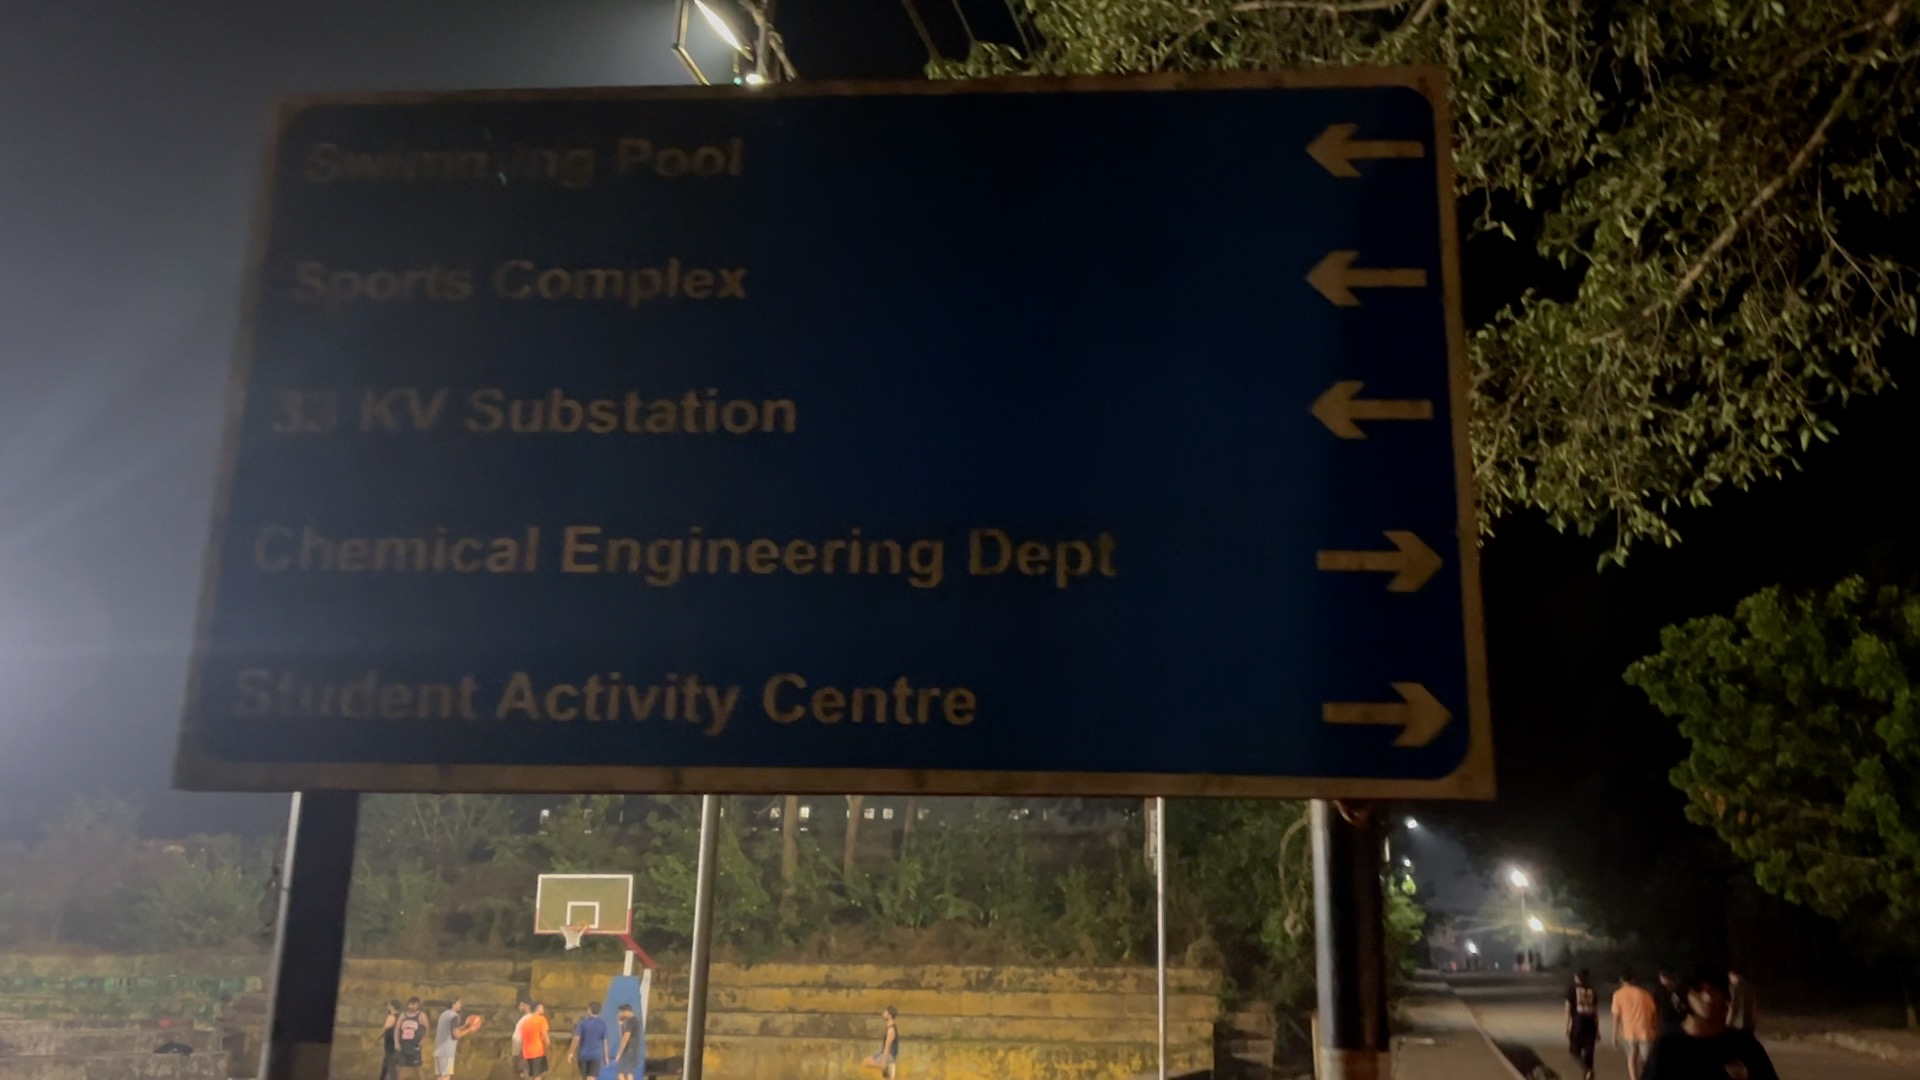

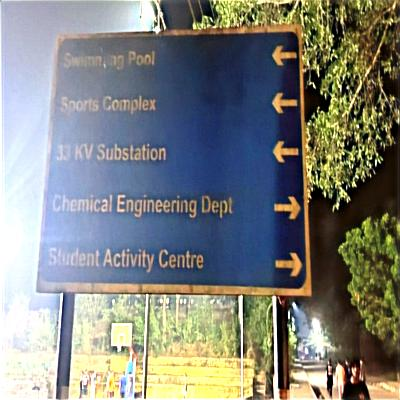


✅ Done. Results are in: /content/drive/MyDrive/mirnet_outputs


In [28]:
#@title Enhance all images and save to Drive
from IPython.display import display

saved_paths = []
for idx, ipath in enumerate(input_images, 1):
    oname = f"{ipath.stem}_enhanced.jpg"
    opath = Path(drive_output_dir) / oname
    run_mirnet_tflite(model_path, ipath, opath)
    saved_paths.append(str(opath))
    print(f"[{idx}/{len(input_images)}] Saved:", opath)

if saved_paths:
    print("\nPreview of first result:")
    display(load_image_rgb(input_images[0]))
    display(Image.open(saved_paths[0]))

print("\n✅ Done. Results are in:", drive_output_dir)